In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from keras.metrics import mean_absolute_error as mae
from keras.saving import register_keras_serializable
import tkinter as tk
from tkinter import *
from PIL import Image, ImageTk
import imutils
import os

@register_keras_serializable()
def custom_mae(y_true, y_pred):
    return mae(y_true, y_pred)

# Définir custom_objects
custom_objects = {'mae': custom_mae}

# Charger les modèles
model1 = load_model(r'C:\Users\cojan\OneDrive\Documents\Yann\DEVELOPPEMENT\pyton\Project_age_gender\Model\Model_age_gender_180v4.h5', custom_objects=custom_objects)
model2 = load_model(r'C:\Users\cojan\OneDrive\Documents\Yann\DEVELOPPEMENT\pyton\Project_age_gender\Model\Model_age_gender_180v2.h5', custom_objects=custom_objects)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


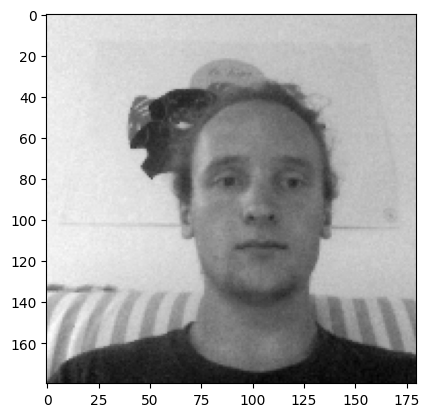

In [28]:
cropped_image = np.array(0)
#---------------mettre l'image au bonne dimension--------------------------------
def convert_image480_data(pixel_list):
    # Suppose que les données d'image sont stockées en format 1D
    # Reshape en 3D (480, 640, 3)
    image_array = np.array(pixel_list).reshape((480, 640, 3))
    
    # Rogner l'image pour obtenir une taille finale de (480, 480, 3)
    cropped_image = image_array[:, 80:560, :]
    
    return cropped_image
def retailler_img(img=cropped_image, size=(180, 180)):
    # Redimensionner l'image en 128x128
    resized_image = cv2.resize(img, size)

    # Convertir en noir et blanc
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    return gray_image
#--------------------------------------------------------------------------------
def prediction_1():    #Dictionnaire homme/femme
    Image = cv2.imread('Photo_128.jpg', cv2.IMREAD_GRAYSCALE)
    Image = Image/255
    gender_dict = {0:'Male', 1:'Female'}
    #affichage des donnée réels
    #print('Original gender: ', gender_dict[y_gender[Image], 'Original age : ', y_age[Image])
    #affichage des prdictions du model
    pred1 = model1.predict(Image.reshape(1, 180, 180, 1))
    pred_gender1 = gender_dict[round(pred1[0][0][0])]
    pred_age1 = round(pred1[1][0][0])

    pred2 = model2.predict(Image.reshape(1, 180, 180, 1))
    pred_gender2 = gender_dict[round(pred2[0][0][0])]
    pred_age2 = round(pred2[1][0][0])

    label_pred_gender1.config(text=f"Model 1 Gender: {pred_gender1}")
    label_pred_age1.config(text=f"Model 1 Age: {pred_age1}")
    label_pred_gender2.config(text=f"Model 2 Gender: {pred_gender2}")
    label_pred_age2.config(text=f"Model 2 Age: {pred_age2}")
    return(pred_gender1, pred_age1, pred_gender2, pred_age2)

# Créer une fenêtre Tkinter
fenetre = tk.Tk()
fenetre.geometry("1500x900")
fenetre.title("Video")
fenetre.resizable(height=False, width=False)
fenetre.config(background='#41B77F')

# Déclaration globale de la capture vidéo
video = None

# Déclaration de la variable pour stocker la dernière image capturée
derniere_image = None

# DataFrame pandas pour stocker les images
df_images = pd.DataFrame(columns=['Image'])
image_flat = []

# Limite maximale d'images dans le DataFrame
MAX_IMAGES = 100

# Fonction pour démarrer le flux vidéo
def video_stream():
    global video
    video = cv2.VideoCapture(0)
    lancer()

# Fonction pour afficher le flux vidéo dans l'interface
def lancer():
    global video
    ret, frame = video.read()
    if ret == True:
        etq_de_video.place(x=20, y=15)
        frame = imutils.resize(frame, width=640)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)
        image = ImageTk.PhotoImage(image=img)
        etq_de_video.configure(image=image)
        etq_de_video.image = image
        etq_de_video.after(10, lancer)
    else:
        video.release()

# Fonction pour prendre une photo
def prendre_photo():
    global derniere_image, df_images, image_flat

    if len(df_images) >= MAX_IMAGES:
        print(f"Le nombre maximum d'images ({MAX_IMAGES}) a été atteint.")
        return

    if video:
        ret, frame = video.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            derniere_image = Image.fromarray(frame_rgb)

            # Convertir l'image en tableau NumPy
            image_np = np.array(derniere_image)
            # Aplatir l'image en un vecteur unidimensionnel
            image_flat = image_np.flatten()

            # Ajouter l'image au DataFrame
            df_images.loc[len(df_images)] = [image_flat]

            # Afficher la dernière image capturée dans un label
            image_tk = ImageTk.PhotoImage(image=derniere_image)
            etq_photo.configure(image=image_tk)
            etq_photo.image = image_tk
    return image_flat 

def im_pour_model(im = image_flat):
    image_data = image_flat
    cropped_image = convert_image480_data(image_data)
    model_image = retailler_img(img=cropped_image, size=(180, 180))
    if os.path.exists("Photo_128.jpg"):
        os.remove("Photo_128.jpg")
    cv2.imwrite('Photo_128.jpg', model_image)
    plt.imshow(model_image, cmap="gray")
    #plt.axis('off')
    return model_image

def sauv_plus_prendre():
    prendre_photo()
    im_pour_model()

# Fonction pour arrêter la capture vidéo
def quitter():
    global video
    etq_de_video.place_forget()
    if video:
        video.release()

label_pred_gender1 = tk.Label(fenetre, text="", bg="#F9429E", font=("Courier", 12, "bold"))
label_pred_gender1.place(x=350, y=700)

label_pred_age1 = tk.Label(fenetre, text="", bg="#F9429E", font=("Courier", 12, "bold"))
label_pred_age1.place(x=350, y=750)

label_pred_gender2 = tk.Label(fenetre, text="", bg="#F9429E", font=("Courier", 12, "bold"))
label_pred_gender2.place(x=650, y=700)

label_pred_age2 = tk.Label(fenetre, text="", bg="#F9429E", font=("Courier", 12, "bold"))
label_pred_age2.place(x=650, y=750)

# Couleur des boutons
couleur_btn = "#5e17eb"

# Bouton pour démarrer la vidéo
bouton_demarrer = tk.Button(fenetre, text="Démarrer la vidéo", bg=couleur_btn, command=video_stream, width=20, height=2, font=("Courier", 12, "bold"))
bouton_demarrer.place(x=100, y=590)

# Bouton pour prendre une photo
bouton_photo = tk.Button(fenetre, text="Prendre une photo", bg=couleur_btn, command=sauv_plus_prendre, width=20, height=2, font=("Courier", 12, "bold"))
bouton_photo.place(x=625, y=590)

# Bouton pour quitter la vidéo
bouton_quitter = tk.Button(fenetre, text="Quitter la vidéo", bg=couleur_btn, command=quitter, width=20, height=2, font=("Courier", 12, "bold"))
bouton_quitter.place(x=1150, y=590)

#bouton prediction
bouton_prediction = tk.Button(fenetre, text='Predict gender & age', bg=couleur_btn, command= prediction_1, width=50, height=0, font=("Courier", 18, "bold"))
bouton_prediction.place(x = 350, y = 650)

# Label pour afficher le flux vidéo
etq_de_video = tk.Label(fenetre, bg="black")
etq_de_video.place(x=20, y=15)

# Label pour afficher la dernière photo capturée
etq_photo = tk.Label(fenetre, bg="black")
etq_photo.place(x=800, y=15)

# Lancement de la boucle principale Tkinter
fenetre.mainloop()

